In [82]:
import tensorflow as tf
import keras
from keras import backend as bk
import timeit

import sys
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

from scipy.integrate import ode
import math as mt
import numpy as np
import matplotlib.pyplot as plt
import random as rdm
import time
from datetime import datetime
import matplotlib.animation as animation
from IPython.display import display, clear_output

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [130]:
##############################################################################################################
###################################### Linear Modules ########################################################
##############################################################################################################


class linear_module_up:
    
    def __init__(self):
        self.a11 = tf.Variable(rdm.choice([-1,1])*rdm.random()) #tf.constant(rdm.random()) 
    
    def run(self, X):
        L = tf.concat([[[1., self.a11]], [[0., 1.]]], 0)
        return tf.matmul(L, X)
    
    def Variables(self):
        return [self.a11]
    
    def grad_des(self, grad, rate):
        self.a11 = tf.Variable(self.a11 - rate*grad)

        
class linear_module_low:
    
    def __init__(self):
        self.a11 = tf.constant(rdm.choice([-1,1])*rdm.random()) #tf.Variable(rdm.random())
    
    def run(self, X):
        L = tf.concat([[[1., 0.]], [[self.a11, 1.]]], 0)
        return tf.matmul(L, X)
    
    def Variables(self):
        return [self.a11]
    
    def grad_des(self, grad, rate):
        self.a11 = tf.Variable(self.a11 - rate*grad)

##############################################################################################################
###################################### Activation Modules ####################################################
##############################################################################################################

class activation_module_up:
    
    def __init__(self):
        self.a1 = tf.constant(rdm.choice([-1,1])*rdm.random()) #tf.Variable(rdm.random())        
    
    def run(self, X):
                    
        return  tf.reshape(tf.stack([X[0] + self.a1*tf.math.sigmoid(X[1]), X[1]]),(2,1))

    
    def Variables(self):
        return [self.a1]
    
    def grad_des(self, grad, rate):

        self.a1 = tf.Variable(self.a1 - rate*grad)

        
class activation_module_low:
    
    def __init__(self):
        self.a1 = tf.constant(rdm.choice([-1,1])*rdm.random()) #tf.Variable(rdm.random())
        
    
    def run(self, X):

        return tf.reshape(tf.stack([X[0], X[1] + self.a1*tf.math.sigmoid(X[0])]),(2,1))

    
    def Variables(self):
        return [self.a1]
    
    def grad_des(self, grad, rate):

        self.a1 = tf.Variable(self.a1 - rate*grad)

        


### Reversible SympNet: $$ \phi_{t = \Delta t} = L_{1}L_{2}  A_{1}  L_{3}L_{4}L_{3}  A_{2}  L_{2}L_{1}$$

In [135]:
class Rev_SympNet:

    def __init__(self):
        
        self.L1 = linear_module_up()
        self.L2 = linear_module_low()
        
        self.A1 = activation_module_up()
        
        self.L3 = linear_module_up()
        self.L4 = linear_module_low()


    def run(self, X):
        
        boom = self.L1.run(X)
        boom1 = self.L2.run(boom)
        
        boom2 = self.A1.run(boom1)
        
        boom3 = self.L3.run(boom2)
        boom4 = self.L4.run(boom3)
        boom5 = self.L3.run(boom4)
        
        boom6 = self.A1.run(boom5)
        
        boom7 = self.L3.run(boom6)
        boom8 = self.L4.run(boom7)
        boom9 = self.L3.run(boom8)
        
        boom7 = self.L2.run(boom6)
        boom8 = self.L1.run(boom7)

        return boom8
    
    
    ##################################### Loss function ##########################
    
    def get_loss(self, X, X_target):
        
        loss = 0
        for i,j in zip(X,X_target):
            loss = loss + tf.norm(self.run(i) - j)**2
                    
        return loss/(len(X)*2)

    
    ################################### get gradient ############################
    
    def get_grad(self, X, X_target):
        
        with tf.GradientTape() as tape:
            
            tape.watch(self.L1.Variables())
            tape.watch(self.L2.Variables())
            
            tape.watch(self.A1.Variables())

            tape.watch(self.L3.Variables())
            tape.watch(self.L4.Variables())
            
            
            L = self.get_loss(X, X_target)
            
            g = tape.gradient(L, [self.L1.Variables(), self.L2.Variables(), self.A1.Variables(), self.L3.Variables(), self.L4.Variables()])
        
        return [item for sublist in g for item in sublist]

    ################################## perform gradient descent ##################
    
    def network_learn(self, X, X_target, rate):
        
        g = self.get_grad( X, X_target)
                
        self.L1.grad_des(g[0], rate)
        self.L2.grad_des(g[1], rate)
        
        self.A1.grad_des(g[2], rate)
        
        self.L3.grad_des(g[3], rate)
        self.L4.grad_des(g[4], rate)


### Non-Reversible SympNet: $$ \phi_{t = \Delta t} = L_{1}L_{2}  A_{1}  L_{3}L_{4}L_{3}  A_{2}$$

In [136]:
class NonRev_SympNet:

    def __init__(self):
        
        self.L1 = linear_module_up()
        self.L2 = linear_module_low()
        
        self.A1 = activation_module_up()
        
        self.L3 = linear_module_up()
        self.L4 = linear_module_low()


    def run(self, X):
        
        boom = self.L1.run(X)
        boom1 = self.L2.run(boom)
        
        boom2 = self.A1.run(boom1)
        
        boom3 = self.L3.run(boom2)
        boom4 = self.L4.run(boom3)
        boom5 = self.L3.run(boom4)
        
        boom6 = self.A1.run(boom5)
        
        #boom7 = self.L3.run(boom6)
        #boom8 = self.L4.run(boom7)
        #boom9 = self.L3.run(boom8)
        
        #boom7 = self.L2.run(boom6)
        #boom8 = self.L1.run(boom7)

        return boom6
    
    
    ##################################### Loss function ##########################
    
    def get_loss(self, X, X_target):
        
        loss = 0
        for i,j in zip(X,X_target):
            loss = loss + tf.norm(self.run(i) - j)**2
                    
        return loss/(len(X)*2)

    
    ################################### get gradient ############################
    
    def get_grad(self, X, X_target):
        
        with tf.GradientTape() as tape:
            
            tape.watch(self.L1.Variables())
            tape.watch(self.L2.Variables())
            
            tape.watch(self.A1.Variables())

            tape.watch(self.L3.Variables())
            tape.watch(self.L4.Variables())
            
            
            L = self.get_loss(X, X_target)
            
            g = tape.gradient(L, [self.L1.Variables(), self.L2.Variables(), self.A1.Variables(), self.L3.Variables(), self.L4.Variables()])
        
        return [item for sublist in g for item in sublist]

    ################################## perform gradient descent ##################
    
    def network_learn(self, X, X_target, rate):
        
        g = self.get_grad( X, X_target)
                
        self.L1.grad_des(g[0], rate)
        self.L2.grad_des(g[1], rate)
        
        self.A1.grad_des(g[2], rate)
        
        self.L3.grad_des(g[3], rate)
        self.L4.grad_des(g[4], rate)


### Training Dataset

In [137]:
def leapfrog(q0, p0, Δt, N):
    q = [q0]
    p = [p0]
    p̄ = []
    for i in range(N):
        p̄.append(p[-1] - 0.5*Δt*mt.sin(q[-1]))
        q.append(q[-1] + Δt*p̄[-1])
        p.append(p̄[-1] - 0.5*Δt*mt.sin(q[-1]))
    
    X = []
    for i,j in zip(p,q):
        X.append(tf.constant([[i],[j]]))
    return X[0:len(X)-1], X[1:]

def plot_true_tr(leapfrog, q0, p0, Δt, N):
    X = leapfrog(q0, p0, Δt, N)[0]
    q = []
    p = []
    for i in range(len(X)):
        q.append(X[i][0].numpy()[0])
        p.append(X[i][1].numpy()[0])
    plt.plot(p, q)

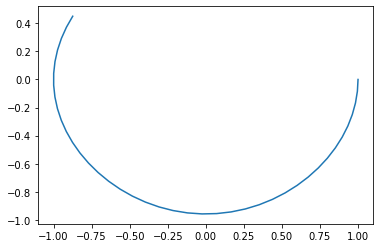

In [138]:
q0 = 1.
p0 = 0.
Δt = 0.1
N = 40

X = leapfrog(q0, p0, Δt, N)
plot_true_tr(leapfrog, q0, p0, Δt, N)

### Training

In [168]:
Model_Rev = Rev_SympNet()
Model_NonRev = NonRev_SympNet()
losses = []

In [178]:
N_train = 1000
rate = 0.01

start_time = time.time()

for i in range(N_train):
    if i%10==0:
        print(Model_Rev.get_loss(X[0], X[1]))
    Model_Rev.network_learn(X[0], X[1], rate)
    losses.append(Model_Rev.get_loss(X[0],X[1]))

print("running time : %s seconds" % (time.time() - start_time))


start_time = time.time()

for i in range(N_train):
    if i%10==0:
        print(Model_NonRev.get_loss(X[0], X[1]))
    Model_NonRev.network_learn(X[0], X[1], rate)
    losses.append(Model_NonRev.get_loss(X[0],X[1]))

print("running time : %s seconds" % (time.time() - start_time))

tf.Tensor(0.0010061612, shape=(), dtype=float32)
tf.Tensor(0.00084110524, shape=(), dtype=float32)
tf.Tensor(0.0007031821, shape=(), dtype=float32)
tf.Tensor(0.00058794074, shape=(), dtype=float32)
tf.Tensor(0.0004916572, shape=(), dtype=float32)
tf.Tensor(0.00041122077, shape=(), dtype=float32)
tf.Tensor(0.0003440258, shape=(), dtype=float32)
tf.Tensor(0.0002878966, shape=(), dtype=float32)
tf.Tensor(0.00024101243, shape=(), dtype=float32)
tf.Tensor(0.00020185302, shape=(), dtype=float32)
tf.Tensor(0.00016914637, shape=(), dtype=float32)
tf.Tensor(0.00014183015, shape=(), dtype=float32)
tf.Tensor(0.00011901718, shape=(), dtype=float32)
tf.Tensor(9.996516e-05, shape=(), dtype=float32)
tf.Tensor(8.405499e-05, shape=(), dtype=float32)
tf.Tensor(7.076837e-05, shape=(), dtype=float32)
tf.Tensor(5.967268e-05, shape=(), dtype=float32)
tf.Tensor(5.0407434e-05, shape=(), dtype=float32)
tf.Tensor(4.2670417e-05, shape=(), dtype=float32)
tf.Tensor(3.6209844e-05, shape=(), dtype=float32)
tf.Tensor

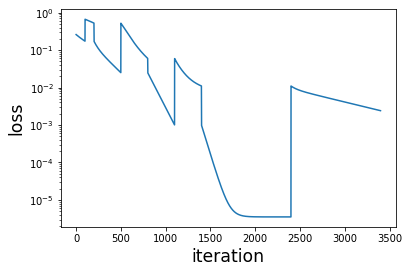

In [179]:
plt.plot(losses)
plt.yscale("log")
plt.xlabel("iteration", fontsize = "xx-large")
plt.ylabel("loss", fontsize = "xx-large")
plt.show()

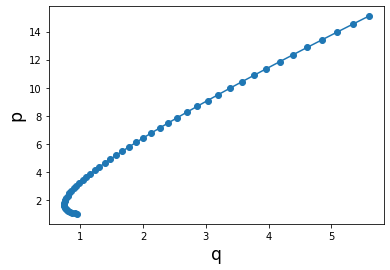

In [182]:
#X_test = tf.constant([[p0],[q0]])

X_test = tf.constant([[1.],[1.]])
Model = Model_NonRev

p = [Model.run(X_test)[0]]
q = [Model.run(X_test)[1]]

run = [Model.run(X_test)]

for i in range(50):
    run.append(Model.run(run[-1]))
    p.append(run[-1][0])
    q.append(run[-1][1])
    
    
plt.plot(q, p, marker = "o") #, linewidth = 0)
#plot_true_tr(leapfrog, q0, p0, Δt, 40)
plt.xlabel("q", fontsize = "xx-large")
plt.ylabel("p", fontsize = "xx-large")
plt.show()

### Reversing Symmetry:

## $$ R \phi_{t} R = \phi_{-t} $$

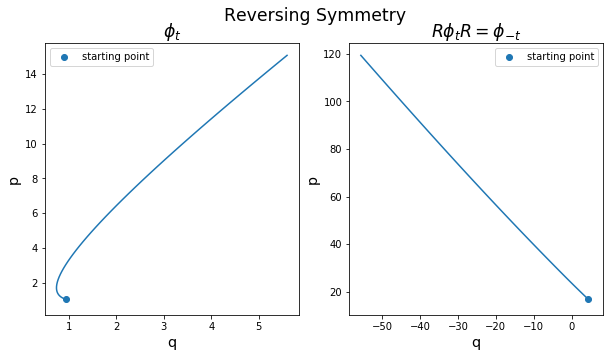

In [184]:
### R-reversibility
def R(X):
    R = tf.concat([[[-1., 0.]], [[0., 1.]]], 0)
    return tf.matmul(R,X)

Model = Model_NonRev

X_test = tf.constant([[1.],[1.]])
N_test = 50

p_f = [Model.run(X_test)[0]]
q_f = [Model.run(X_test)[1]]
run = [Model.run(X_test)]

for i in range(N_test):
    run.append(Model.run(run[-1]))
    p_f.append(run[-1][0])
    q_f.append(run[-1][1])


X_test = run[-1]

p_b = [R(Model.run(R(X_test)))[0]]
q_b = [R(Model.run(R(X_test)))[1]]
run = [R(Model.run(R(X_test)))]

for i in range(N_test):
    run.append(R(Model.run(R(run[-1]))))
    p_b.append(run[-1][0])
    q_b.append(run[-1][1])


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Reversing Symmetry', fontsize = "xx-large")


ax1.plot(q_f, p_f)
ax1.scatter(q_f[0], p_f[0], label = "starting point")
ax1.legend()
#ax1.set_xlim((0., 2.))
#ax1.set_ylim((-1.5, 1.1))
ax1.set_xlabel("q", fontsize = "x-large")
ax1.set_ylabel("p", fontsize = "x-large")
ax1.set_title("$\phi_{t}$", fontsize = "xx-large")
#plt.show()


ax2.plot(q_b, p_b)
ax2.scatter(q_b[0], p_b[0], label = "starting point")
ax2.legend()
#ax2.set_xlim((0., 2.))
#ax2.set_ylim((-1.5, 1.1))
ax2.set_xlabel("q", fontsize = "x-large")
ax2.set_ylabel("p", fontsize = "x-large")
ax2.set_title("$R \phi_{t} R = \phi_{-t}$", fontsize = "xx-large")

plt.show()